## Backtesting Base Class ##

In [433]:
#
# Based on
# Python Script with Base Class
# for Event-based Backtesting
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'


class BacktestBase(object):
    ''' Base class for event-based backtesting of trading strategies.

    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to be used
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: float
        amount to be invested either once or per trade
    ftc: float
        fixed transaction costs per trade (buy or sell)
    ptc: float
        proportional transaction costs per trade (buy or sell)

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    plot_data:
        plots the closing price for the symbol
    get_date_price:
        returns the date and price for the given bar
    print_balance:
        prints out the current (cash) balance
    print_net_wealth:
        prints auf the current net wealth
    place_buy_order:
        places a buy order
    place_sell_order:
        places a sell order
    close_out:
        closes out a long or short position
    '''

    raw = None
    active_backtest_dataset = None
    
    def __init__(self, symbol, amount, ftc=0.0, ptc=0.0,
                 start=None, end=None, verbose=True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_amount = amount
        self.current_balance = amount
        self.ftc = ftc
        self.ptc = ptc
        self.units = 0
        self.position = 0
        self.trades = 0
        self.verbose = verbose
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''   
        if self.raw is None:
            print("Retrieving data...")
            self.raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                              index_col=0, parse_dates=True).dropna()
        self.data = pd.DataFrame(self.raw[self.symbol].copy())
        if self.start is not None:
            self.data = self.data.loc[self.start:]
        if self.end is not None:
            self.data = self.data.loc[:self.end]
        self.data.rename(columns={self.symbol: 'price'}, inplace=True)
        self.data['return'] = np.log(self.data['price'] / self.data['price'].shift(1))
        self.data.dropna(inplace=True)

    def plot_data(self, cols=None):
        ''' Plots the closing prices for symbol.
        '''
        if cols is None:
            cols = ['price']
        self.data['price'].plot(figsize=(10, 3), title=self.symbol)

    def get_date_price(self, bar):
        ''' Return date and price for bar.
        '''
        date = str(self.active_backtest_dataset.index[bar])[:10]
        price = self.active_backtest_dataset.price.iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.current_balance:.2f}')

    def print_net_wealth(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.current_balance
        print(f'{date} | current net wealth {net_wealth:.2f}')

    def place_buy_order(self, bar, units=None, amount=None):
        ''' Place a buy order.
        '''
        date, price = self.get_date_price(bar)
        if self.verbose:
            print(f'{date} | Units before trade: {self.units}')
        if units is None:
            units = int(amount / price)
        self.current_balance -= (units * price) * (1 + self.ptc) + self.ftc
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | BUY {units} units at {price:.2f} - value: {(price*units):.2f}')
            print(f'{date} | Units after trade: {self.units}')
            self.print_balance(bar)
            #self.print_net_wealth(bar)

    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if self.verbose:
            print(f'{date} | Units before trade: {self.units}')
        if units is None:
            units = int(amount / price)
        self.current_balance += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | SELL {units} units at {price:.2f} - value: {(price*units):.2f}')
            self.print_balance(bar)
            print(f'{date} | Units after trade: {self.units}')
            #self.print_net_wealth(bar)

    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)

        if self.verbose:
            print(f'{date} | *** CLOSING OUT FINAL POSITION ***')
            print(f'{date} | Liquidating inventory: {self.units} units at {price:.2f}')
        if self.units < 0:
            self.place_buy_order(bar, units=-self.units)
        else:
            self.place_sell_order(bar, units=self.units)

        perf = ((self.current_balance - self.initial_amount) / self.initial_amount * 100)
        trading_days = len(self.active_backtest_dataset)      
        start_price = self.get_date_price(0)[1]
        end_price = self.get_date_price(len(self.active_backtest_dataset) -1)[1]
        market_perf = (end_price -start_price )/start_price * 100
        
        print('=' * 57)
        print(f'Final balance                 [$] {self.current_balance:.2f}')
        print(f'Market Performance            [%] {market_perf:.2f}')
        print(f'Strategy Net Performance      [%] {perf:.2f}')
        print(f'Market Performance Annualised [%] {(market_perf/trading_days * 252):.2f}')      
        print(f'Strategy Net Perf. Annualised [%] {(perf/trading_days * 252):.2f}')
        print(f'Number of trades              [#] {self.trades}')
        print(f'Avg. # trades per day         [#] {(self.trades/trading_days):.1f}')
        print('=' * 57)
        print('=' * 57)

#if __name__ == '__main__':
#    bb = BacktestBase('AAPL.O', '2010-1-1', '2019-12-31', 10000)
#    print(bb.data.info())
#    print(bb.data.tail())
#    bb.plot_data()
#    # plt.savefig('../../images/ch06/backtestbaseplot.png')


In [434]:
#bt = BacktestBase("EUR=", start='2012-01-01', end='2015-12-31', amount=10000, ftc=3)
bt = BacktestBase("EUR=", amount=10000, ftc=3)

Retrieving data...


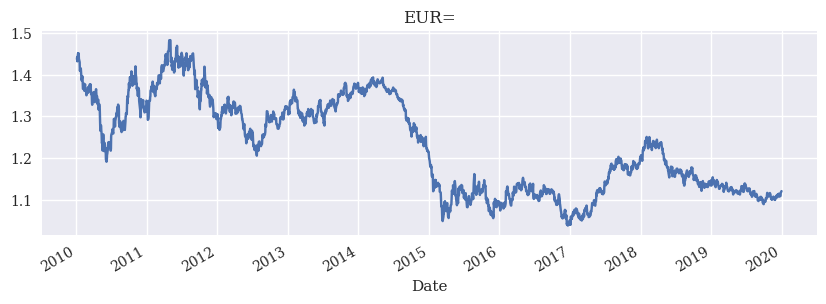

In [435]:
bt.plot_data()

In [436]:
#bt.raw.columns

In [437]:
#bt.data

## ML event based backtesting

In [438]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [450]:
class BacktestML(BacktestBase):
    
    models = None
    train_test_split_percentage = 0.70
    lags = 7
    base_features = []
    lagged_features = []
    
    def setup_models(self):
        print("Setting up ML models...")
        self.models = {'gauss': GaussianNB(),
                       'logreg': LogisticRegression(C=1, solver='lbfgs', max_iter=500),
                       'dtc': DecisionTreeClassifier(max_depth=7),
                       'svm': SVC(C=1, gamma='auto', kernel='linear'),
                       'mlp': MLPClassifier(hidden_layer_sizes=[64], shuffle=False,
                                max_iter=1000)}
        
    def prepare_features(self):
        print("Prepring features...")
        self.base_features = ['SMA1',
                'SMA2',
                'SMA_dif',
                'EWMA1',
                'EWMA2',
                'EWMA_dif',
                'VOLAT1',
                'VOLAT2']
        SMA1 = 42   #42
        SMA2 = 127  #252
        EWMA1 = 15  #37
        EWMA2 = 55  #157
        VOLAT1 = 5  #10
        VOLAT2 = 21 #50
        
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()
        self.data['SMA_dif'] = self.data['SMA1'] - self.data['SMA2']
        self.data['EWMA1'] = self.data['price'].ewm(halflife=EWMA1).mean()
        self.data['EWMA2'] = self.data['price'].ewm(halflife=EWMA2).mean()
        self.data['EWMA_dif'] = self.data['EWMA1'] - self.data['EWMA2']
        self.data['VOLAT1'] = self.data['return'].rolling(VOLAT1).std()
        self.data['VOLAT2'] = self.data['return'].rolling(VOLAT2).std()
        self.data.dropna(inplace=True)
        
        # Apply train/test split, then calculate mu and std for normalization based on train data
        # Then apply calculated mu & std to feature columns of entire data set
        
        split = int(len(self.data) * self.train_test_split_percentage)
        train = self.data.iloc[:split]
        
        mu, std = train[self.base_features].mean(), train[self.base_features].std()
        self.data[self.base_features] -= mu
        self.data[self.base_features] /= std
        
        # Add direction,
        self.data['d'] = np.where(self.data['return'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

        bins = [-0.025, -0.02, -0.015, -0.01, -0.005, 0.005, 0.01, 0.015, 0.02, 0.025,]
        self.data['d_bins'] = np.digitize(self.data['return'], bins=bins)

        self.base_features.extend(['return', 'd', 'd_bins'])

    def add_lags_to_features(self):
        print(f'Adding {self.lags} lags to all features...')
        self.lagged_features = []
        for col in self.base_features:
            for lag in range(1, self.lags + 1):
                col_ = col + f'_lag_{lag}'
                #train[col_] = train[col].shift(lag)
                #test[col_] = test[col].shift(lag)
                self.data[col_] = self.data[col].shift(lag)
                self.lagged_features.append(col_)
        #train.dropna(inplace=True)
        #test.dropna(inplace=True)
        self.data.dropna(inplace=True)
    
    def create_train_test_data_split(self):
        print(f'Creating training ({self.train_test_split_percentage*100:.0f}%) and testing ({(1-self.train_test_split_percentage)*100:.0f}%) data split...')
        split = int(len(self.data) * self.train_test_split_percentage)
        self.train_data = self.data.iloc[:split].copy()
        self.test_data = self.data.iloc[split:].copy()

    def fit_models(self, select_k_best=True, select_k=15, models_to_test=None):
        print("Fitting models to training data...")
        if select_k_best is True:
            selector = SelectKBest(f_classif, k=select_k)
            cols_sel = selector.fit(self.train_data[self.lagged_features], self.train_data['d']).get_support(indices=True)
            self.lagged_features = self.train_data[self.lagged_features].columns[cols_sel]
            # print(f"SelectKBest cols: {self.lagged_features}")
            print(f"Selecting {select_k} best features...")
        
        if models_to_test is None:
            models_to_test = self.models 
        for m in models_to_test:
            model = self.models[m]
            model.fit(self.train_data[self.lagged_features], self.train_data['d'])
            
            # Complete in-sample performance calcs
            self.train_data['p_' + m] = model.predict(self.train_data[self.lagged_features])
            self.train_data['p_' + m] = np.where(self.train_data['p_' + m] == 1, 1, -1)
            self.train_data['s_' + m] = self.train_data['p_' + m] * self.train_data['return']
            perf_train = self.train_data[['return', 's_' + m]].sum().apply(np.exp)

            # Complete out-of-sample performance calcs
            self.test_data['p_' + m] = model.predict(self.test_data[self.lagged_features])
            self.test_data['p_' + m] = np.where(self.test_data['p_' + m] == 1, 1, -1)
            self.test_data['s_' + m] = self.test_data['p_' + m] * self.test_data['return']
            perf_test = self.test_data[['return', 's_' + m]].sum().apply(np.exp)

            print(f"Model {m}:")
            print(f"   In-sample: Buy-and-hold returns:      {perf_train[0]:.2f}")
            print(f"   In-sample: Model returns:             {perf_train[1]:.2f}")
            print(f"   Out-of-sample: Buy-and-hold returns:  {perf_test[0]:.2f}")
            print(f"   Out-of-sample: Model returns:         {perf_test[1]:.2f}")
    
            #self.train_data[['return', 's_' + m]].cumsum().apply(np.exp).plot(title=f'{self.symbol} | {m} | in-sample')
            
            #plt.figure(figsize=(15, 5))
            #plt.plot(self.train_data['return'].cumsum().apply(np.exp), lw=1.5, label=f'Buy-and-hold returns: {round(float(perf[0]),2)}')
            #plt.plot(self.train_data['s_' + m].cumsum().apply(np.exp), lw=1.5)#, label=f'Strategy returns: {round(float(perf[1]),2)}')
            #plt.ylabel('Returns')
            #plt.title(f'{self.symbol} | {m} | in-sample')

            
    def backtest_ml_model(self, bt_data, model, model_name):
        start_date = str(bt_data.index[0])[:10]
        end_date = str(bt_data.index[len(bt_data)-1])[:10]
        
        msg = f"Running ML strategy: {model_name} | {self.symbol}"
        msg += f'\nDate range: {start_date} - {end_date}'
        msg += f'\nfixed costs {self.ftc:.2f} | '
        msg += f'proportional costs {(self.ptc*100):.2f}%'
        print(msg)
        #print('=' * 57+"\n")        
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_amount  # reset initial capital
        
        for bar in range(1, len(bt_data)):
            date, price = self.get_date_price(bar)
            position = 1 if model.predict(bt_data[self.lagged_features])[bar] == 1 else -1
            
            if self.position in [0, -1] and position == 1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                self.place_buy_order(bar - 1,
                                     amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            elif self.position in [0, 1] and position == -1:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1,
                                      amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
         
        self.close_out(bar)
    
    def run_ml_strategies(self, train_test_split_percentage=0.7, lags=5,
                          vec_bt_only=False, select_k_best=False, select_k=15,
                          models_to_test=None):
        self.train_test_split_percentage = train_test_split_percentage
        self.lags = lags
        if self.models is None:
            self.setup_models()
        if models_to_test is None:
            models_to_test = self.models
        print('\n' + '#' * 57)
        print('## FEATURE PREPARATION #')
        print('#' * 57)
        self.prepare_features()
        print(f'Base features: {self.base_features}')
        self.add_lags_to_features()
        self.create_train_test_data_split()
        print('\n' + '#' * 57)
        print('## MODEL FITTING TO TRAINING DATASET #')
        print('#' * 57)
        self.fit_models(select_k_best=select_k_best, select_k=select_k, models_to_test=models_to_test)
        
        if vec_bt_only is not True:
            print('\n' + '#' * 57)
            print('## EVENT BASED BACKTESTING FOR SELECTED MODELS #')
            print('#' * 57)
            for m in models_to_test:
                
                #print('=== IN-SAMPLE =======')
                #print('=====================')
                #self.active_backtest_dataset = self.train_data
                #self.backtest_ml_model(self.active_backtest_dataset, self.models[m], m)
                print('=====================')
                print('=== OUT-OF-SAMPLE ===')
                print('=====================')
                self.active_backtest_dataset = self.test_data
                self.backtest_ml_model(self.active_backtest_dataset, self.models[m], m)

    

In [451]:
bt.raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [452]:
mlbt = BacktestML(".VIX", start='2010-01-01', end='2019-12-31', 
                  amount=10000, ftc=0, verbose=False)

Retrieving data...


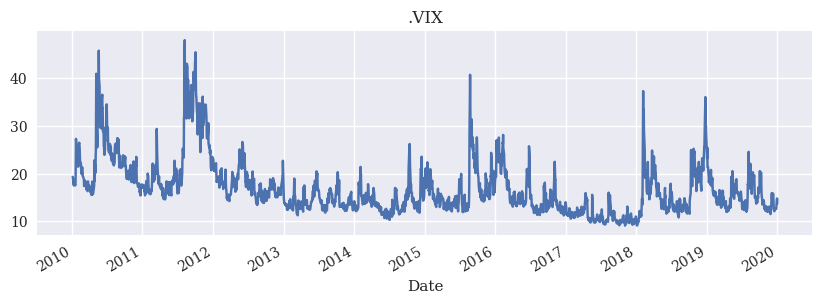

In [453]:
mlbt.plot_data()

In [454]:
mlbt.run_ml_strategies(vec_bt_only=False, select_k_best=True, select_k=20, 
                       train_test_split_percentage=0.7)#, models_to_test=['gauss','logreg'])

Setting up ML models...

#########################################################
## FEATURE PREPARATION #
#########################################################
Prepring features...
Base features: ['SMA1', 'SMA2', 'SMA_dif', 'EWMA1', 'EWMA2', 'EWMA_dif', 'VOLAT1', 'VOLAT2', 'return', 'd', 'd_bins']
Adding 5 lags to all features...
Creating training (70%) and testing (30%) data split...

#########################################################
## MODEL FITTING TO TRAINING DATASET #
#########################################################
Fitting models to training data...
Selecting 20 best features...
Model gauss:
   In-sample: Buy-and-hold returns:      0.49
   In-sample: Model returns:             17582.47
   Out-of-sample: Buy-and-hold returns:  1.14
   Out-of-sample: Model returns:         329.33
Model logreg:
   In-sample: Buy-and-hold returns:      0.49
   In-sample: Model returns:             886142.40
   Out-of-sample: Buy-and-hold returns:  1.14
   Out-of-sample: Model r